In [82]:
import pandas as pd
import numpy as np
import shap
from floridaman import data_cleaning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

In [47]:
# load in data
raw_data = data_cleaning.load('null_transformed')

In [48]:
candidate_data = data_cleaning.generate_candidate_dataset(raw_data, .40, .40, 5)
train_data = data_cleaning.balance(candidate_data)

X_train = np.array(train_data[data_cleaning.features(train_data)])
y_train = np.array(train_data['FAILURETYPE'])

X_test = np.array(candidate_data[data_cleaning.features(candidate_data)])
y_test = np.array(candidate_data['FAILURETYPE'])

### Optimize Random Forest through Random Search

In [49]:
# Specify hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 4, stop = 10, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [50]:
# Create the hyperparameter grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [51]:
# Create a basic RF classifier
rf_model = RandomForestClassifier()

# Create grid search object with specified parameter grid. Perform 
# cross validation with 8 folds to randomly select combinations of hyperparameters 
# from random_grid and return the combination that performs the best.
rf_grid = GridSearchCV(estimator = rf_model, param_grid = random_grid, cv = 8, verbose = 2, n_jobs = 4)

# Fit classifier to X_train and y_train
rf_grid.fit(X_train, y_train)

Fitting 8 folds for each of 4320 candidates, totalling 34560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 516 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 1328 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 2460 tasks      | elapsed:   32.6s
[Parallel(n_jobs=4)]: Done 3920 tasks      | elapsed:   50.8s
[Parallel(n_jobs=4)]: Done 5700 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 7808 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 10236 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 12992 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 16068 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 19472 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 23196 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 27248 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 31620 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done 34553 out of 34560 | elap

GridSearchCV(cv=8, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              random_state=None, verbose=0,
                                   

In [65]:
# Create better model with tuned hyperparameters
best_model = rf_grid.best_estimator_

### Random Forest Results

In [83]:
print("Scoring method: roc_auc_ovo score")
print("Classifier ROC score: " + str(roc_auc_score(y_train, best_model.predict_proba(X_train), multi_class='ovo'))) # prints roc score from training set
print("Classifier testing score: " + str(best_model.score(X_test, y_test))) # prints best roc score using all data as test
print("Classifier training score: " + str(best_model.score(X_train, y_train)))
print("Best combination of hyperparameters: ") 
rf_grid.best_params_ # prints the best combination of hyperparameters for our data set 

Scoring method: roc_auc_ovo score
Classifier ROC score: 0.9982963429718313
Classifier testing score: 0.6828246558946739
Classifier training score: 0.9758454106280193
Best parameters: 


{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 8}

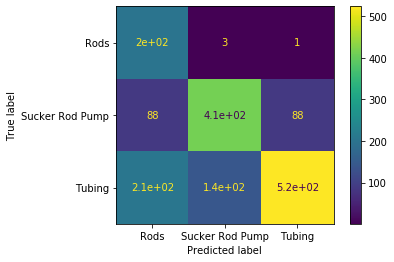

In [78]:
# Plot the confusion matrix
cm = plot_confusion_matrix(best_model, X_test, y_test)

# SHAP 

In [79]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [94]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test, feature_names = data_cleaning.features(train_data))

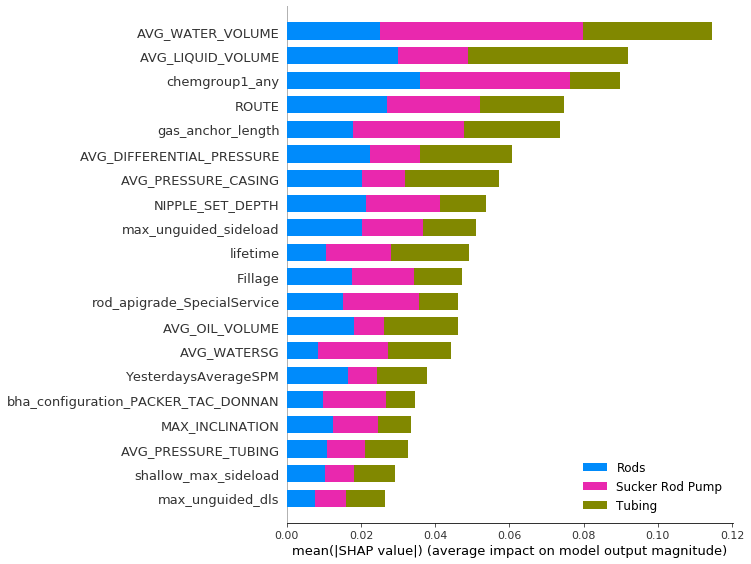

In [92]:
shap.summary_plot(shap_values, X_test, feature_names = data_cleaning.features(train_data), class_names = ['Rods', 'Sucker Rod Pump', 'Tubing'])